In [9]:
from keras.models import load_model
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [10]:
import nltk
from nltk.util import ngrams
import spacy 
import numpy
import pandas as pd
import seaborn as sns

In [11]:
#%%time
#nlp=spacy.load('en_vectors_web_lg')
%time nlp=spacy.load('./wikipedia-pubmed-and-PMC-w2v')
%time model=load_model('./model/lstm.h5')

CPU times: user 51.6 s, sys: 7.29 s, total: 58.9 s
Wall time: 58.9 s


In [13]:
def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

In [14]:
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('./model/classes.npy')

### write code for n gram

In [15]:
#sent='Large outbreak of pre-XDR TB Argentina'
sent='Japanese experience with dual-action antidepressants'

Text(0.5,24,'words in sentence')

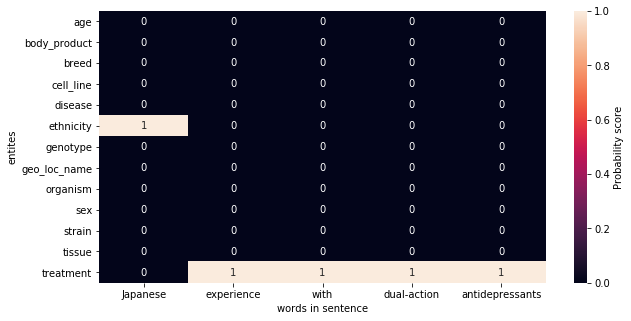

In [16]:
tokens=sent.split(' ')
s=sent.split(' ')

scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
for n_gram in range(1,len(tokens)):
    grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
    #print (grams)
    val_docs = list(nlp.pipe(grams))
    val_X=get_features(val_docs,max_length=model.input_shape[1])
    tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
    """
    each n gram only advange 
    """
    for i,word in enumerate(tmpDf.index):
        for j,one_gram in enumerate(word.split(' ')):
            scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
            
displayHmap=scoreDf.T
fig,ax=plt.subplots(figsize=(10,5))
#displayHmap[displayHmap.max(axis=1)<0.5]=0
sns.heatmap(data=displayHmap>0.9,ax=ax,cbar_kws={'label':'Probability score'},annot=True)
ax.set_ylabel('entites')
ax.set_xlabel('words in sentence')